# CH02.1. **Training Utility - Scheduler**

#### [][][][][]

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [ ]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 100
USE_PRETRAIN_YN = 'N'
MODEL_PTH = '../../model/bostonRegScheduler.pt'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import random
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import torch
import torchinfo

#(2) Set options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)
torch.mps.manual_seed(seed=SEED_NUM)

#(3) Define device(hardware)
if torch.backends.mps.is_available() :
    device = torch.device(device='mps')
else :
    device = torch.device(device='cpu')
print(f'>> Device : {device}')

>> Device : mps


#### 00.2. **사용자정의함수 정의**

In [3]:
#(1) Define `describe_df()` function
def describe_df(df:pd.DataFrame) :
    output = pd.DataFrame(data={
        'dataType'     : df.dtypes,
        'nullCount'    : df.isnull().sum(),
        'nonNullCount' : (df.shape[0]-df.isnull().sum()),
        'uniqueCount'  : df.nunique()
    })
    return output

#(2) Define `compute_rmse()` function
def compute_rmse(model:torch.nn.Module, loader:torch.utils.data.DataLoader) :
    model.eval()
    with torch.no_grad() : 
        square_sum = 0
        instance_num = 0
        for inputs, targets in loader :
            preds = model(x=inputs)
            square_sum += torch.sum(
                input=(preds-targets.to(device=preds.device))**2
            ).item()
            instance_num += len(targets)
    model.train()
    output = np.sqrt(square_sum/instance_num)
    return output

#### 00.3. **클래스 정의**

In [ ]:
#(1) Define `MyTensorDataset` class
class MyTensorDataset(torch.utils.data.Dataset) :
    def __init__(self, df:pd.DataFrame, pred_label_nm:'str', data_type:torch.dtype=torch.float32) :
        self.feature = torch.tensor(data=df.drop(labels=pred_label_nm, axis=1).values, dtype=data_type)
        self.label = torch.tensor(data=df.loc[:, pred_label_nm].values, dtype=data_type).reshape(shape=(-1, 1))
        self.len = self.label.shape[0]
    def __getitem__(self, index) :
        return self.feature[index], self.label[index]
    def __len__(self) :
        return self.len

#(2) Define `MyRegressionModel` class
class MyRegressionModel(torch.nn.Module) :
    def __init__(self, input_shape:tuple, device:torch.device) :
        super().__init__()
        self.device = device
        self.layers = torch.nn.ModuleDict()
        dims = [input_shape[0], 128, 64, 32]
        for i in range(len(dims)-1) :
            fc_block = torch.nn.ModuleList(modules=[
                torch.nn.Linear(in_features=dims[i], out_features=dims[i+1]),
                torch.nn.BatchNorm1d(num_features=dims[i+1]),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.2)
            ])
            self.layers[f'fc_{i}'] = fc_block
        layer = torch.nn.Linear(in_features=dims[-1], out_features=input_shape[1])
        self.layers[f'fc_{i+1}'] = layer
        self.to(device=device)
    def forward(self, x:torch.Tensor) :
        x = x.to(device=self.device)
        _layers = list(self.layers.values())
        for fc_block in _layers[:-1]:
            for layer in fc_block:
                x = layer(x)
        x = _layers[-1](x)
        return x
    
#(3) Define `EarlyStopping` class
class EarlyStopping :
    def __init__(self, patience:int=3, verbose:bool=False) :
        self.patience = patience
        self.verbose = verbose
        self.loss_best = float('inf')
        self.counter = 0
        self.should_stop = False
    def check(self, loss_val:float):
        if loss_val < self.loss_best :
            self.loss_best = loss_val
            self.counter = 0 
        else :
            self.counter += 1
            if self.verbose == True :
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience :
                self.should_stop = True

<b></b>

## 01. **학습 보조기능 - 학습률 스케줄러(Learning Rate Scheduler)**

#### (1) **정의** : **[CONTENTS]**

<b></b>

## 02. **데이터셋 로드 및 전처리**

In [5]:
#(1) 
boston_raw = pd.read_csv(filepath_or_buffer='../../data/boston.csv', index_col=[0])

#(2)
boston_train, boston_test = sklearn.model_selection.train_test_split(boston_raw, train_size=0.7, random_state=SEED_NUM)

#(3)
boston_train = MyTensorDataset(df=boston_train, pred_label_nm='Price', data_type=torch.float32)
boston_test = MyTensorDataset(df=boston_test, pred_label_nm='Price', data_type=torch.float32)

#(4)
boston_train_loader = torch.utils.data.DataLoader(dataset=boston_train, batch_size=BATCH_SIZE, shuffle=True)
boston_test_loader = torch.utils.data.DataLoader(dataset=boston_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 03. **모델 구축 및 학습**

#### 03.1. **모델 정의**

In [6]:
#(1) Define `model`
model = MyRegressionModel(input_shape=(13, 1), device=device)

#(2) Print `model`
# torchinfo.summary(
#     model=model, 
#     input_size=[BATCH_SIZE]+list(boston_train[0][0].shape),
#     device=device
# )

In [ ]:
#(3) Define loss function
criterion = torch.nn.MSELoss()

#(4) Define optimizer(optimization method)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=1e-7)

#(5) Define Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#### 03.2. **학습 전 변수 정의**

In [9]:
batch_cnt = len(boston_train_loader)
if USE_PRETRAIN_YN == 'Y' :
    checkpoint = torch.load(f=MODEL_PTH, map_location=device)
    model.load_state_dict(state_dict=checkpoint['model'])
    optimizer.load_state_dict(state_dict=checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss_hist = checkpoint['loss_hist']
    best_loss = loss_hist[-1]
else :
    epoch = 0
    loss_hist = []
    best_loss = float('inf')
print(f">> Epoch={epoch}, Train Loss={best_loss}")

>> Epoch=0, Train Loss=inf


#### 03.3. **모델 학습**

In [10]:
progress_bar = tqdm.trange(epoch, EPOCH_NUM)
for epoch in progress_bar : 
    running_loss = 0.0
    model.train()
    for inputs, targets in boston_train_loader :
        optimizer.zero_grad() 
        preds = model(x=inputs)
        loss = criterion(input=preds, target=targets.to(device=device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss_avg = running_loss / batch_cnt
    loss_hist.append(running_loss_avg)
    # if running_loss_avg < best_loss :
    #     best_loss = running_loss_avg
    #     torch.save(
    #         obj={
    #             'epoch'     : epoch,
    #             'loss_hist' : loss_hist,
    #             'model'     : model.state_dict(),
    #             'optimizer' : optimizer.state_dict()
    #         }, 
    #         f=MODEL_PTH
    #     )
    scheduler.step()  # update scheduler
    progress_bar.set_postfix(ordered_dict={'epoch':epoch+1, 'loss':running_loss_avg}) 

100%|██████████| 100/100 [00:13<00:00,  7.38it/s, epoch=100, loss=0.0142]


<b></b>

## 04. **모델 평가**

#### 04.1. **최적 성능 모델 로드**

In [11]:
# checkpoint = torch.load(f=MODEL_PTH, map_location=device)
# model.load_state_dict(state_dict=checkpoint['model'])
# print(f'>> Epoch : {checkpoint["epoch"]}, Loss : {checkpoint["loss_hist"][-1]}')

#### 04.2. **과소 적합 확인**

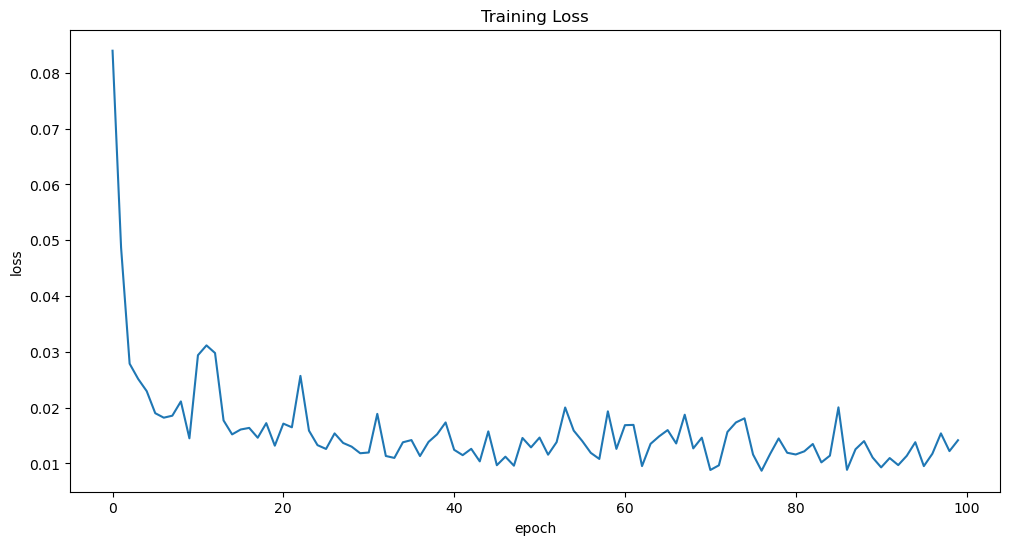

In [ ]:
#(1) Plot traing loss
plt.figure(figsize=(12, 6))
plt.title(label='Training Loss')
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_hist)
plt.show()

In [ ]:
#(2) Check RMSE
rmse_train = compute_rmse(model=model, loader=boston_train_loader)
print(f'>> Train RMSE: {rmse_train}')

>> Train RMSE: 0.07907147591003141


#### 04.3. **일반화 성능 평가**

In [14]:
rmse_test = compute_rmse(model=model, loader=boston_test_loader)
print(f'>> Test RMSE : {rmse_test}')

>> Test RMSE : 0.11181092035105239
